In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


mpl.rcParams['figure.dpi'] = 300

In [2]:
torch.cuda.get_device_name(0)
torch.cuda.empty_cache()

In [3]:
class ExudateClassifier(nn.Module):
    def __init__(self):
        super(ExudateClassifier, self).__init__()
        self.conv = nn.Sequential()
        self.conv.add_module("Pad1", nn.ConstantPad2d((0,1,0,1), 0))
        self.conv.add_module("Conv1", nn.Conv2d(3, 32, kernel_size=2))
        self.conv.add_module("BN1", nn.BatchNorm2d(32))
        self.conv.add_module("Relu1", nn.ReLU())
        
        self.conv.add_module("Pad2", nn.ConstantPad2d((0,1,0,1), 0))
        self.conv.add_module("Conv2", nn.Conv2d(32, 32, kernel_size=2))
        self.conv.add_module("BN2", nn.BatchNorm2d(32))
        self.conv.add_module("Relu2", nn.ReLU())
        self.conv.add_module("Layer2MaxPool", nn.MaxPool2d(2))
        
        self.conv.add_module("Pad3", nn.ConstantPad2d((0,1,0,1), 0))
        self.conv.add_module("Conv3", nn.Conv2d(32, 64, kernel_size=2))
        self.conv.add_module("BN3", nn.BatchNorm2d(64))
        self.conv.add_module("Relu3", nn.ReLU())
        
        self.conv.add_module("Pad4", nn.ConstantPad2d((0,1,0,1), 0))
        self.conv.add_module("Conv4", nn.Conv2d(64, 64, kernel_size=2))
        self.conv.add_module("BN4", nn.BatchNorm2d(64))
        self.conv.add_module("Relu4", nn.ReLU())
        self.conv.add_module("Layer4MaxPool", nn.MaxPool2d(2))
                             
        self.conv.add_module("Pad5", nn.ConstantPad2d((0,1,0,1), 0))
        self.conv.add_module("Conv5", nn.Conv2d(64, 128, kernel_size=2))
        self.conv.add_module("BN5", nn.BatchNorm2d(128))
        self.conv.add_module("Relu5", nn.ReLU())
        
        self.conv.add_module("Pad6", nn.ConstantPad2d((0,1,0,1), 0))
        self.conv.add_module("Conv6", nn.Conv2d(128, 128, kernel_size=2))
        self.conv.add_module("BN6", nn.BatchNorm2d(128))
        self.conv.add_module("Relu6", nn.ReLU())
        self.conv.add_module("Layer6MaxPool", nn.MaxPool2d(2))
        
        self.conv.add_module("Pad7", nn.ConstantPad2d((0,1,0,1), 0))
        self.conv.add_module("Conv7", nn.Conv2d(128, 256, kernel_size=2))
        self.conv.add_module("BN7", nn.BatchNorm2d(256))
        self.conv.add_module("Relu7", nn.ReLU())
        
        self.conv.add_module("Pad8", nn.ConstantPad2d((0,1,0,1), 0))
        self.conv.add_module("Conv8", nn.Conv2d(256, 256, kernel_size=2))
        self.conv.add_module("BN8", nn.BatchNorm2d(256))
        self.conv.add_module("Relu8", nn.ReLU())
        
        self.fc = nn.Sequential()
        self.fc.add_module("FC1", nn.Linear(4096, 1000))
        self.fc.add_module("Dropout1", nn.Dropout(0.5))
        self.fc.add_module("FC2", nn.Linear(1000, 100))
        self.fc.add_module("Dropout1", nn.Dropout(0.5))
        self.fc.add_module("FC3",nn.Linear(100, 2)) 
        self.fc.add_module("Dropout1", nn.Dropout(0.5))
    
    def forward(self, x):
        x = self.conv(x)

        x = x.view(x.shape[0], -1)
        
        x = self.fc(x)
        return x

In [4]:
model = ExudateClassifier()
model.cuda()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = F.cross_entropy

In [5]:
# Load the image names
import os
import os.path
import cv2

from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image as imgutil

# train_path_truths = os.path.join("Data_Group_Component_Task_1", "Train", "masks_Hard_Exudates")
train_path_images = os.path.join("Data_Group_Component_Task_1", "Train", "original_retinal_images")
train_path_exudates = os.path.join("Data_Group_Component_Task_1", "Train", "masks_Hard_Exudates")
train_image_names = os.listdir(train_path_images)
train_exudate_names = list(map(lambda x: x.split('.')[0] + '_EX.tif', train_image_names))

images = list(map(
    lambda x: cv2.resize(
        cv2.imread(
            os.path.join(train_path_images, x)
        ), (256, 256)
    ), train_image_names))

exudates = list(map(
    lambda x: cv2.resize(
        cv2.imread(
            os.path.join(train_path_exudates, x)
        ), (256, 256)
    )[:,:,2], train_exudate_names))

exudates = [(exudate != 0).astype(np.uint8) for exudate in exudates]

In [6]:
def get_labelled_patches(img, truth):
    img = np.dstack((img, truth))
    patches = imgutil.extract_patches_2d(img, (32,32))
    np.random.shuffle(patches)
    positive_patches = []
    negative_patches = []
    for patch in patches:
              
        truth = patch[16,16,3]
        patch = patch[:,:,:3]
        patch = np.rollaxis(patch,2,0)

        if truth != 0:
            positive_patches.append(torch.from_numpy(patch))
        else:
            negative_patches.append(torch.from_numpy(patch))
            
    return torch.stack(positive_patches), torch.stack(negative_patches)

In [45]:
def load_data():
    
    patches = []
    labels = []
    
    for image, exudate in zip(images, exudates):
        pos, neg = get_labelled_patches(image, exudate)
        patches.extend(pos)
        patches.extend(neg)

        pos_l = torch.ones(len(pos))
        neg_l = torch.zeros(len(neg))
        labels.extend(pos_l)
        labels.extend(neg_l)

    
    print(patches[0].shape)
    print(len(labels))
    
    image_tensor = torch.stack(patches)
    label_tensor = torch.stack(labels)
    return image_tensor, label_tensor

In [ ]:
image_tensor, label_tensor = load_data()

In [42]:
import torch.utils.data as utils
epochs = 500
batch_size = 100

train_dataset = utils.TensorDataset(image_tensor, label_tensor)
train_dataloader = utils.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

In [43]:
print("Samples:", len(train_dataloader))

Samples: 1196


In [44]:
losses_per_epoch = []

for epoch in range(0, epochs):
    model.train()
    losses_per_batch = []
    
    for i, data in enumerate(train_dataloader):
        patches, labels = data
        output = model(patches.cuda().float())
        
        optimizer.zero_grad()
        loss = criterion(output, labels.cuda().long())
        loss.backward()
        optimizer.step()
        
        losses_per_batch.append(loss.item())
    
    losses_per_epoch.append(losses_per_batch)
    torch.cuda.empty_cache()
    print("Epoch: {0} Loss:{1}".format(epoch, sum(losses_per_batch)))


Epoch: 0 Loss:6.717984447272837
Epoch: 1 Loss:7.326715778199002
Epoch: 2 Loss:6.0885561900949945
Epoch: 3 Loss:6.006754525265151
Epoch: 4 Loss:6.63946702139819
Epoch: 5 Loss:7.011858862563557
Epoch: 6 Loss:4.60029016828242
Epoch: 7 Loss:6.189557207065931
Epoch: 8 Loss:6.3374296018700775
Epoch: 9 Loss:4.921829436241289
Epoch: 10 Loss:5.411032263520546
Epoch: 11 Loss:5.969780078044948
Epoch: 12 Loss:5.257459442954151


KeyboardInterrupt: 

### Evaluate Visually

In [15]:
test_path_images = os.path.join("Data_Group_Component_Task_1", "Test", "original_retinal_images")
test_path_exudates = os.path.join("Data_Group_Component_Task_1", "Test", "masks_Hard_Exudates")
test_image_names = os.listdir(test_path_images)
test_exudate_names = list(map(lambda x: x.split('.')[0] + '_EX.tif', test_image_names))

test_images = list(map(
    lambda x: cv2.resize(
        cv2.imread(
            os.path.join(test_path_images, x)
        ), (256, 256)
    ), test_image_names))

test_exudates = list(map(
    lambda x: cv2.resize(
        cv2.imread(
            os.path.join(test_path_exudates, x)
        ), (256, 256)
    )[:,:,2], test_exudate_names))

test_exudates = torch.stack([torch.tensor((exudate != 0).astype(np.uint8)) for exudate in test_exudates])

In [34]:
test_number = 14
test_image = test_images[test_number]
patches = imgutil.extract_patches_2d(test_image, (32,32))
generated_mask = []

In [35]:
model.eval()
rolled_patches = [torch.Tensor(np.rollaxis(patch,2,0)) for patch in patches]
rolled_patches_tensor = torch.stack(rolled_patches)
image_patches_dataset = utils.TensorDataset(rolled_patches_tensor)
image_loader = utils.DataLoader(image_patches_dataset, batch_size=225)

for i, image_patch_ in enumerate(image_loader):
    img_patch = image_patch_[0]
    test_output = model(img_patch.cuda())
    labels = torch.argmax(test_output, 1) # convert one hot to index/pixel form
    generated_mask.append(labels.cpu().data.numpy())

generated_mask = np.array(generated_mask)
print(generated_mask.shape)

(225, 225)


(-0.5, 224.5, 224.5, -0.5)

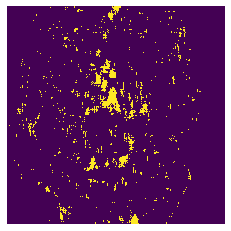

In [36]:
plt.imshow(generated_mask)
plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

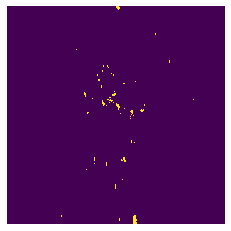

In [37]:
plt.imshow(test_exudates[test_number][16:240,16:240])
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

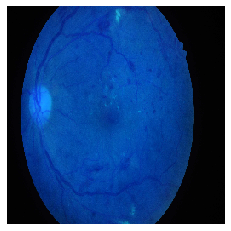

In [38]:
plt.imshow(test_image)
plt.axis('off')